# Data Mining / Prospecção de Dados

## Sara C. Madeira and André Falcão, 2019/20

# Project 1 - Pattern Mining

## Introduction

**In what follows keep the following question in mind and be creative!**

1. What are the most popular products?
2. Which products are bought together?
3. Can you find associations highliting that when people buy a product/set of products also buy other product(s)?

(make_documentation -ReadMe, Requirements file)
* PP_mining
* Algorithms Choice - mlextend does not use multiprocessing LOGO fp growth
* TODO (alternatives)

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first part of the project you should load and preprocessed the dataset **`Foodmart_2020_PD.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

### 1.1. Load and Preprocess Dataset

 **Product quantities and stores should not be considered.**

In [1]:
# Import Libraries

import os
from pp_mining import Pattern, store_groups
from statistics import mean, stdev
import matplotlib.pyplot as plt

#Get directory to files

path = os.getcwd()
path = os.path.join(path,"dataset")
csv_file = os.path.join(path,"Foodmart_2020_PD.csv")

In [2]:
# Load data
all_stores = Pattern(csv_path=csv_file)
all_stores.dataset.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### 1.1.1. EDA

In [132]:
print('{} Items'.format(len(all_stores.dataset.columns)))
print('{} Transactions'.format(len(all_stores.dataset.values)))

102 Items
69549 Transactions


The dataset has many items to evaluate, but it has good proportions (features <<< datapoints)

In [91]:
percents = []
items = all_stores.dataset.columns
for item in items:
    percents.append(all_stores.dataset[item].value_counts('True')[1])
print('Mean Presence: {} % [+- {}]'.format(round(mean(percents)*100,1), round(stdev(percents)*100, 1)))
print('Maximum Presence: {} %'.format(round(max(percents)*100,1)))
print('Minimum Presence: {} %'.format(round(min(percents)*100,1)))

Mean Presence: 4.1 % [+- 3.7]
Maximum Presence: 28.4 %
Minimum Presence: 1.3 %


Having a minimum presence inside the mean's standard deviation, and a maximum that is clearly an outlier, we can access that most items will probably have a small presence in transactions, with some items dominating most of the transactions.

This is most be taken into account, since basic algorithms like **FPGrowth**, or **Apriori** have a basic approach to computing support (single support), which leads to a preference for itemsets with items that have an high presence in transactions. Not having in consideration if an item is a frequently selling item, like basic groceries, or a less frequently sold item, like a computer. A possible solution is using an algorithm that uses a support matrix like **MLApriori**.

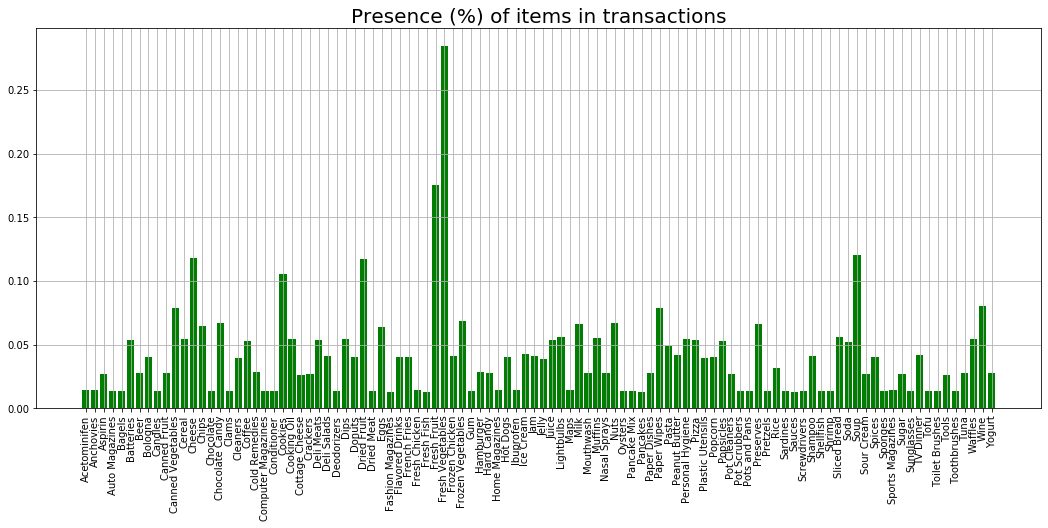

In [129]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.ocean(1)
plt.bar(items, percents, color=color)
plt.title('Presence (%) of items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

Has expected, we have two main outliers, and lots of products sold with a low frequency. Another possible solution, is to remove the outliers, to find other less obvious patterns.

In [97]:
N = 10
top = get_n(percents, items, N)
top

{'Canned Vegetables': 0.07854893672087306,
 'Cheese': 0.11784497260923953,
 'Cookies': 0.1054220765215891,
 'Dried Fruit': 0.11722670347524766,
 'Fresh Fruit': 0.1752864886626695,
 'Fresh Vegetables': 0.28446131504406963,
 'Frozen Vegetables': 0.06834030683403068,
 'Paper Wipes': 0.07896590892751873,
 'Soup': 0.1200592388100476,
 'Wine': 0.08067693280996133}

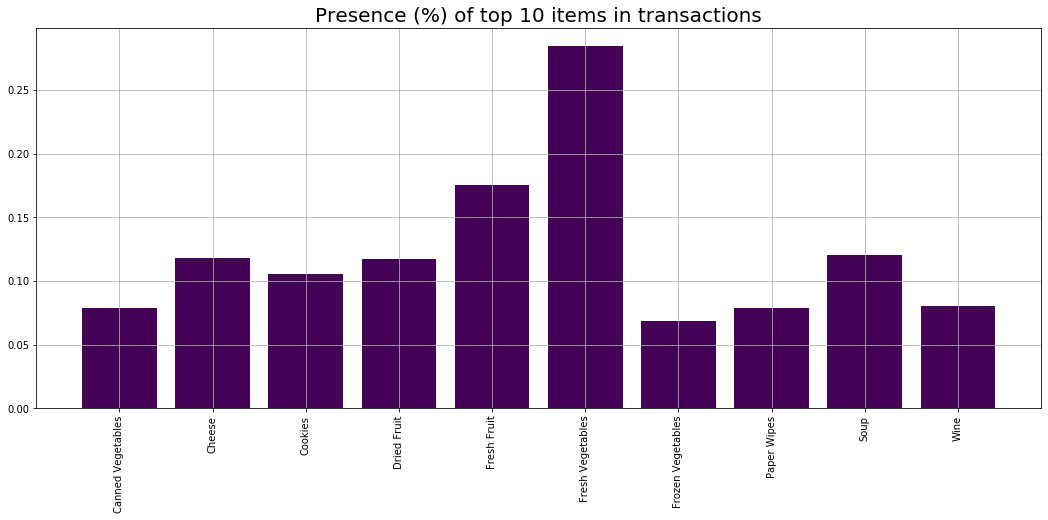

In [107]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(list(top.keys()), list(top.values()), color=color)
plt.title('Presence (%) of top {} items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

Most sold items are, as expected, basic fresh groceries, that need to be bought daily. Analysing which items are bought with this items might be useful, since it tells us what products are sold as extras when people go to buy essencials. Moving this products closer together could entice costumers.  

In [125]:
N = 50
bottom = get_n(percents, items, N, top=False)

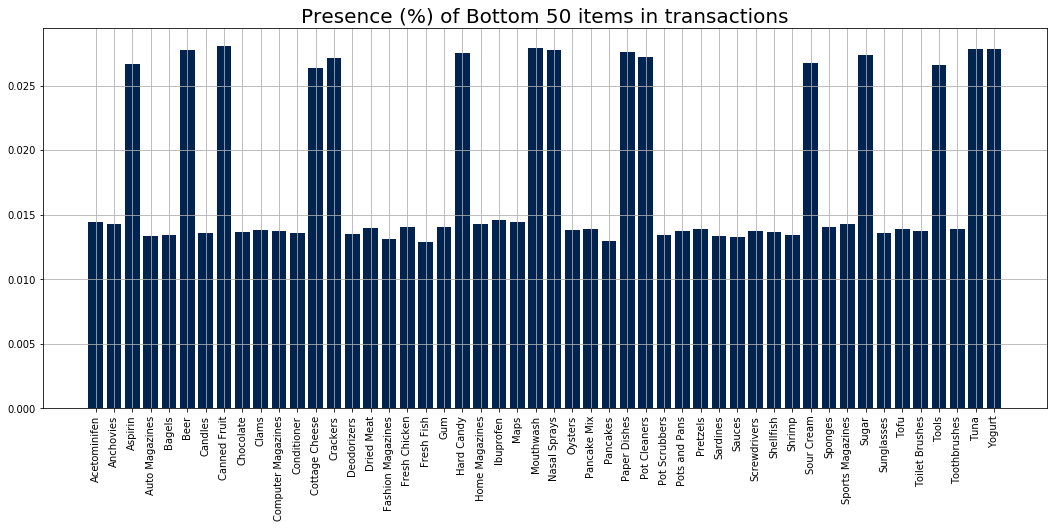

In [126]:
plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.cividis(1)
plt.bar(list(bottom.keys()), list(bottom.values()), color=color)
plt.title('Presence (%) of Bottom {} items in transactions'.format(N), fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

The less sold are more specific items, that can be bought many at a time, in fewer transactions, and since we are not considering, the quantities bought, this items have a visible disadvantage. Since less sold items are much more consistence in terms of consistency, to we might want to remove some outliers in a posterior analyses.

Considering this dataset, and the approach proposed in this project, I would conclude that the analyses that would obtain better results, is opportunist analyses. Where we try to associate daily sold products, that are the reason people normally engage in these transactions, and see what are the non-essencial products, people can be entice to buy.

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

#### Top support

In [12]:
min_support=0.1

frequent = all_stores.create_item_set(min_support=min_support, order=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head()

6 Itemsets with at least 10.0 % support


,support,itemsets
0,0.120059,(Soup)
1,0.284461,(Fresh Vegetables)
2,0.117845,(Cheese)
3,0.105422,(Cookies)
4,0.175286,(Fresh Fruit)


In [17]:
frequent.sort_values('support', ascending=False, inplace=True)
frequent.reset_index(drop=True, inplace=True)
frequent

,support,itemsets
0,0.284461,(Fresh Vegetables)
1,0.175286,(Fresh Fruit)
2,0.120059,(Soup)
3,0.117845,(Cheese)
4,0.117227,(Dried Fruit)
5,0.105422,(Cookies)


By considering a high support (given this dataset), the top selling products appear again, with only 1-itemsets. In this list we have 3 items that need to be bought daily, and 3 products I would access, as convenience products. It will be interesting to see possible association between them.

#### Organized by length

In [166]:
min_support=0.005

frequent = all_stores.create_item_set(min_support=min_support, ascending=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

374 Itemsets with at least 0.5 % support


,support,itemsets
0,0.005334,"(Cheese, Fresh Fruit, Fresh Vegetables)"
1,0.005550,"(Cookies, Fresh Fruit, Fresh Vegetables)"
2,0.007089,"(Soup, Fresh Fruit, Fresh Vegetables)"
3,0.010884,"(French Fries, Fresh Vegetables)"
4,0.013990,"(Waffles, Fresh Vegetables)"
5,0.007592,"(Chips, Cheese)"
6,0.018332,"(Chips, Fresh Vegetables)"
7,0.007304,"(Chips, Dried Fruit)"
8,0.010985,"(Chips, Fresh Fruit)"
9,0.006542,"(Cottage Cheese, Fresh Vegetables)"


The support needs to drop bellow 0.5%, to some 3-itemsets to appear. But we see that as expected, they are normally the combination of essencial, and convenience products.

##### 1-Itemsets

In [188]:
min_support=0.05

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[1,1])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

31 Itemsets with at least 5.0 % support


,support,itemsets
0,0.120059,(Soup)
1,0.284461,(Fresh Vegetables)
2,0.066342,(Milk)
3,0.117845,(Cheese)
4,0.105422,(Cookies)
5,0.066040,(Preserves)
6,0.064070,(Eggs)
7,0.054868,(Dips)
8,0.054321,(Cereal)
9,0.053617,(Deli Meats)


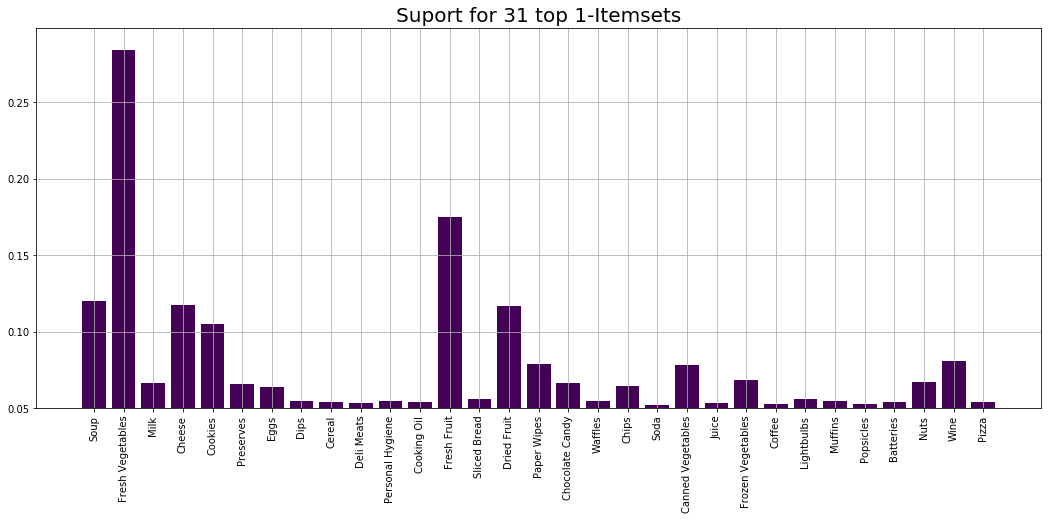

In [189]:
items = [list(item_set)[0] for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(items, frequent['support'].values, color=color)
plt.title('Support for {} top 1-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

##### 2-Itemsets

In [21]:
min_support=0.015

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[2,2])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

30 Itemsets with at least 1.5 % support


,support,itemsets
0,0.035701,"(Fresh Vegetables, Soup)"
1,0.020805,"(Soup, Fresh Fruit)"
2,0.017757,"(Fresh Vegetables, Milk)"
3,0.015227,"(Cheese, Soup)"
4,0.020417,"(Cheese, Fresh Fruit)"
5,0.031201,"(Fresh Vegetables, Cheese)"
6,0.027765,"(Fresh Vegetables, Cookies)"
7,0.018908,"(Cookies, Fresh Fruit)"
8,0.019051,"(Fresh Vegetables, Preserves)"
9,0.018016,"(Fresh Vegetables, Eggs)"


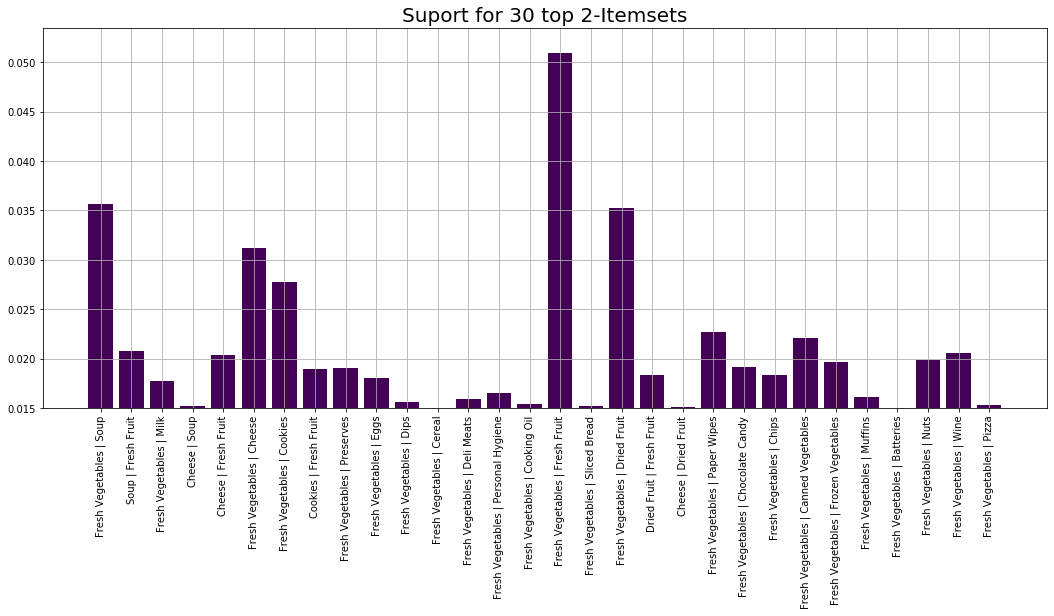

In [22]:
itemsets = ['{} | {}'.format(list(item_set)[0], list(item_set)[1]) for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 2-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

##### 3-Itemsets

In [19]:
min_support=0.003

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[3,3])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

19 Itemsets with at least 0.3 % support


,support,itemsets
0,0.007089,"(Fresh Vegetables, Soup, Fresh Fruit)"
1,0.003451,"(Fresh Vegetables, Milk, Fresh Fruit)"
2,0.004285,"(Fresh Vegetables, Soup, Cheese)"
3,0.005334,"(Fresh Vegetables, Cheese, Fresh Fruit)"
4,0.005550,"(Fresh Vegetables, Cookies, Fresh Fruit)"
5,0.003897,"(Fresh Vegetables, Soup, Cookies)"
6,0.003782,"(Fresh Vegetables, Cookies, Dried Fruit)"
7,0.003221,"(Fresh Vegetables, Preserves, Fresh Fruit)"
8,0.003710,"(Fresh Vegetables, Soup, Dried Fruit)"
9,0.004975,"(Fresh Vegetables, Dried Fruit, Fresh Fruit)"


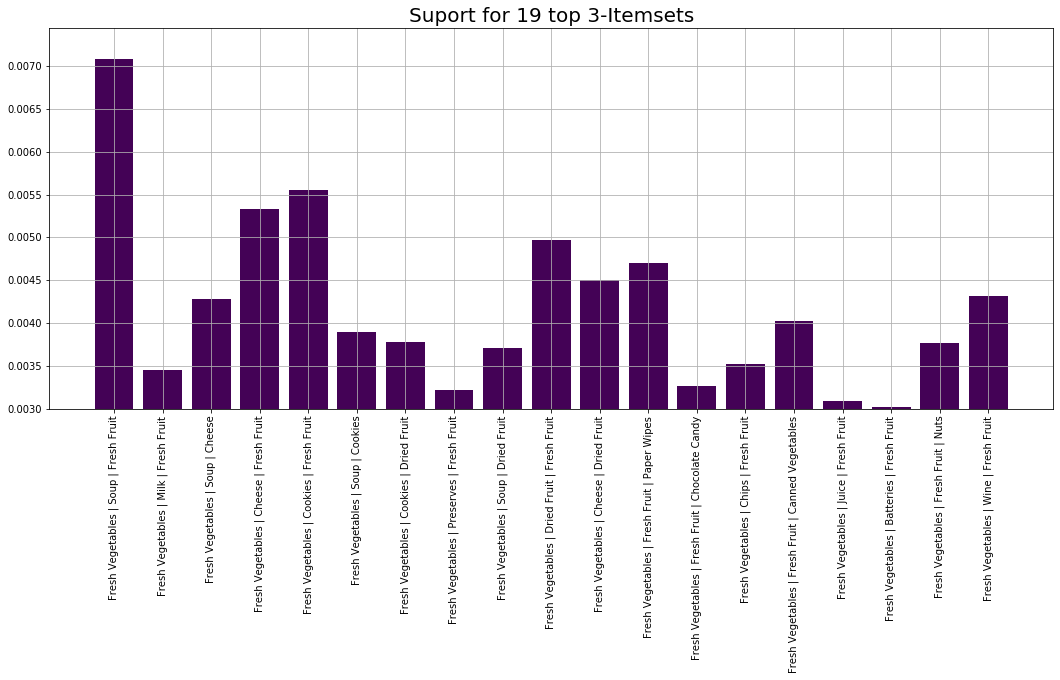

In [20]:
itemsets = ['{} | {} | {}'.format(list(item_set)[0], list(item_set)[1], list(item_set)[2]) 
            for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 3-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

##### 4-Itemsets

In [26]:
min_support=0.0005

frequent = all_stores.create_item_set(min_support=min_support, order=False, length=[4,4])

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

18 Itemsets with at least 0.05 % support


,support,itemsets
0,0.000532,"(Fresh Vegetables, Soup, Milk, Fresh Fruit)"
1,0.000834,"(Fresh Vegetables, Soup, Cheese, Fresh Fruit)"
2,0.000546,"(Fresh Vegetables, Cookies, Cheese, Fresh Fruit)"
3,0.000748,"(Fresh Vegetables, Soup, Cookies, Fresh Fruit)"
4,0.000776,"(Fresh Vegetables, Cookies, Dried Fruit, Fresh..."
5,0.000518,"(Fresh Vegetables, Preserves, Cheese, Fresh Fr..."
6,0.000561,"(Fresh Vegetables, Soup, Fresh Fruit, Cereal)"
7,0.000618,"(Fresh Vegetables, Dried Fruit, Cheese, Fresh ..."
8,0.000546,"(Fresh Vegetables, Fresh Fruit, Dried Fruit, P..."
9,0.000518,"(Fresh Vegetables, Soup, Chips, Fresh Fruit)"


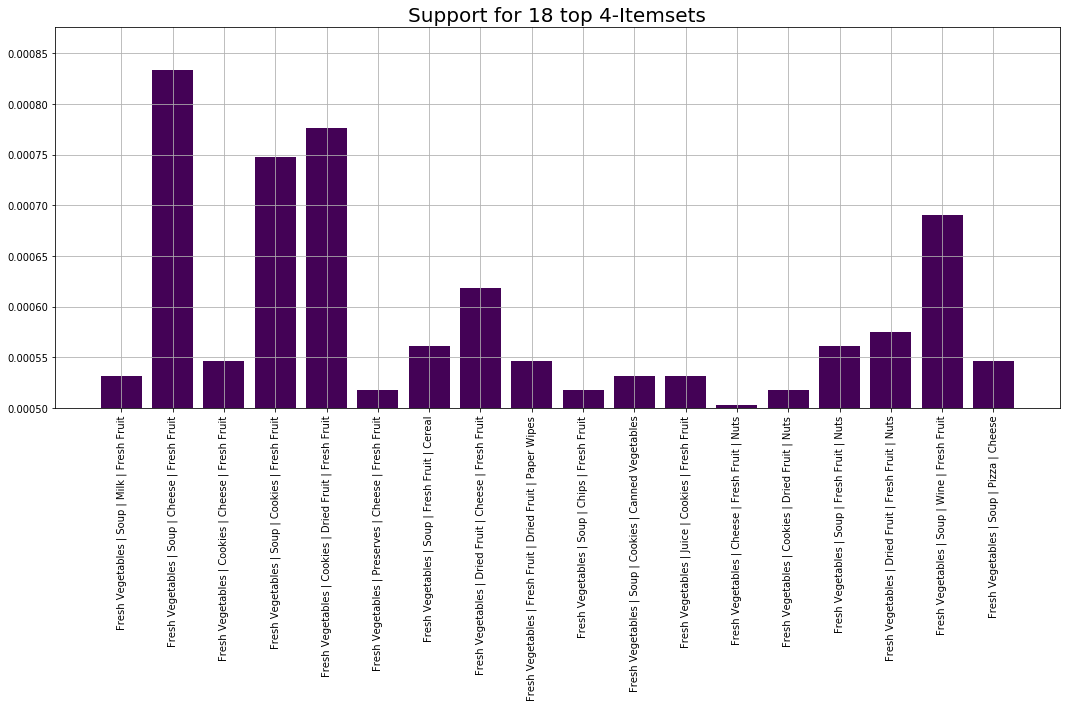

In [28]:
itemsets = ['{} | {} | {} | {}'.format(list(item_set)[0], list(item_set)[1], list(item_set)[2], list(item_set)[3])  
            for item_set in frequent['itemsets'].values]

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.viridis(1)
plt.bar(itemsets, frequent['support'].values, color=color)
plt.title('Support for {} top 4-Itemsets'.format(len(frequent)), fontsize = 20)
plt.xticks(rotation = 90 )
plt.ylim(bottom=min_support)
plt.grid()
plt.show()

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a minimum confidence of C%. 
* Generate association rules with a minimum lift L. 
* Generate association rules with both confidence >= % and lift >= 1.1.
* Change C and L when it makes sense and discuss the results.

In [ ]:
# Write code in cells like this
# ....

In [ ]:
# Removing most sold products
complete_dt = all_stores.dataset
try:
    partial_dt = complete_dt.drop(['Fresh Vegetables', 'Fresh Fruit', 'Soup'], axis=1, inplace=False)
    all_stores.dataset = partial_dt
except KeyError:
    # If already removed re-compute
    all_stores = Pattern(csv_path=csv_file)

Write text in cells like this ...


### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

In [42]:
min_support=0.000001

frequent = all_stores.create_item_set(algorithm='fpmax', min_support=min_support, order=False)

print('{} Itemsets with at least {} % support'.format(len(frequent), min_support*100))
frequent.head(10)

ValueError: min() arg is an empty sequence

Write text in cells like this ...


### 1.5 Conclusions from Mining Frequent Patterns in All Stores

Write text in cells like this ...


## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores, and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store. 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21) and Gourmet Supermarkets (STORE_ID = 4, 6) together**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

In [4]:
stores = {
    'Deluxe Supermarkets' : ['8', '12', '13', '17', '19', '21'],
    'Gourmet Supermarkets': ['4', '6']
}
    

In [5]:
store_groups(csv_file=csv_file, stores=stores)['Deluxe Supermarkets'].dataset.head()            


,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Write text in cells like this ...


#### 2.1.2. Compute Frequent Itemsets

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.3. Generate Association Rules from Frequent Itemsets

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.1.4.  Deluxe/Gourmet Supermarkets versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).

Write text in cells like this 


### 2.2. Analyse Small Groceries [For groups of 2 and 3]

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.2. Compute Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.4 Small Groceries versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this


### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries  [For groups of 2 and 3]

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this

### 2.4. Analyse Supermarkets [Only for groups of 3]

Here you should analyse **Supermarkets (STORE_ID = 1, 3, 7, 10, 11, 15, 16)**. 

Use subsections as in tasks 2.1 and 2.2. 


### 2.5.  Deluxe/Gourmet Supermarkets versus Supermarkets [Only for groups of 3]

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions from Deluxe Supermarkets/Gourmet Supermarkets) and the results obtained in task 2.4. (frequent itemsets and association rules found in transactions from Supermarkets).

Write text in cells like this